<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [49]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [50]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

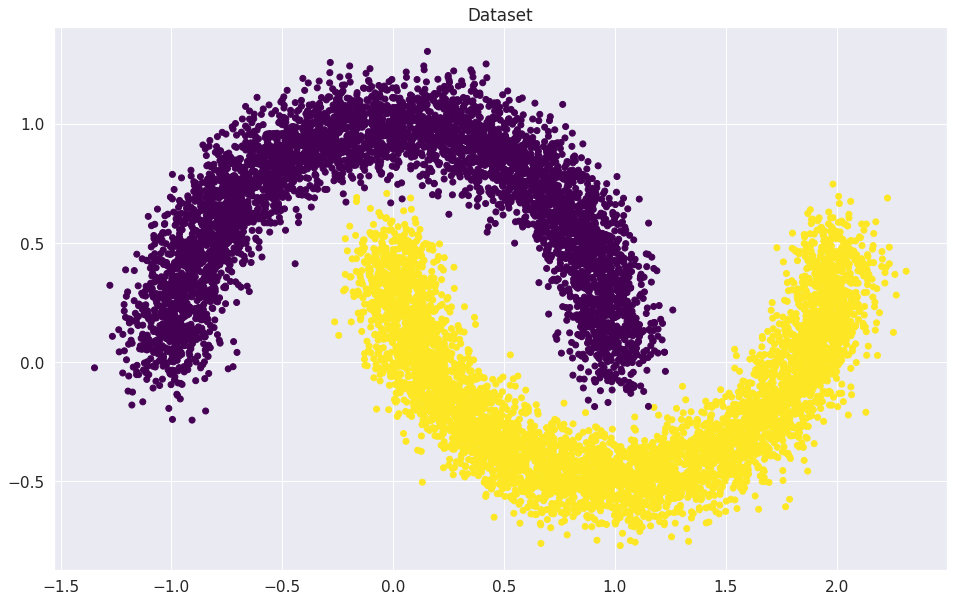

In [51]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [53]:
X_train

array([[ 0.50202001, -0.33758011],
       [-0.02001968,  0.239079  ],
       [ 0.57026061,  0.81166576],
       ...,
       [ 0.32163146, -0.35671524],
       [ 2.01344205,  0.03227946],
       [ 0.17908235,  0.93097468]])

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [54]:
X_train_t = torch.FloatTensor(X_train)  
y_train_t =torch.FloatTensor(y_train)  
y_val_t = torch.FloatTensor(y_val) 

In [55]:
len(X_val_t)

2500

In [56]:
len(y_val_t)

2500

In [57]:
X_train_t

tensor([[ 0.5020, -0.3376],
        [-0.0200,  0.2391],
        [ 0.5703,  0.8117],
        ...,
        [ 0.3216, -0.3567],
        [ 2.0134,  0.0323],
        [ 0.1791,  0.9310]])

Создаем `Dataset` и `DataLoader`. 

In [58]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [59]:
torch.randn((2,1))

tensor([[-1.1668],
        [ 1.3284]])

In [60]:
nn.Parameter(torch.randn(2,))

Parameter containing:
tensor([0.7711, 0.5923], requires_grad=True)

In [61]:
torch.ones(2)

tensor([1., 1.])

In [62]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features,out_features))
        self.bias = bias
        if bias:
            self.bias_term =nn.Parameter(torch.ones(out_features)) 

    def forward(self, x):
        
        x = x @ self.weights
        if self.bias:
            x += self.bias_term 
        return x

In [63]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [64]:
loss_function

BCEWithLogitsLoss()

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [65]:
list(LinearRegression(2,1).parameters())

[Parameter containing:
 tensor([[-1.8225],
         [-1.8064]], requires_grad=True), Parameter containing:
 tensor([1.], requires_grad=True)]

In [66]:
#2 параметра?

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [67]:
n=torch.randn(2,1)
n.size(dim=1)

1

In [68]:
n.view(-1)

tensor([-1.9839,  0.1799])

### Задание. Реализация цикла обучения

In [69]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) 
        outp = outp.view(-1)

        loss =loss_function(outp, y_batch)  
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) 
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.8359375
Iteration: 100
Batch accuracy: 0.875
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.921875
Iteration: 400
Batch accuracy: 0.8984375

Iteration: 401.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 932

### Визуализируем результаты

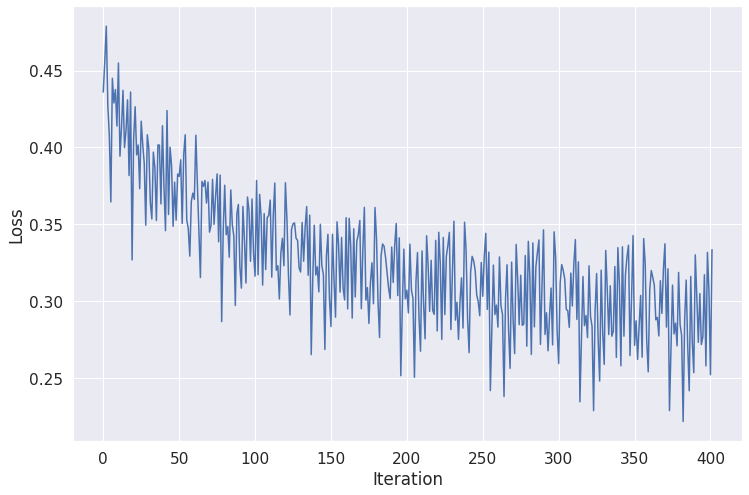

In [70]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

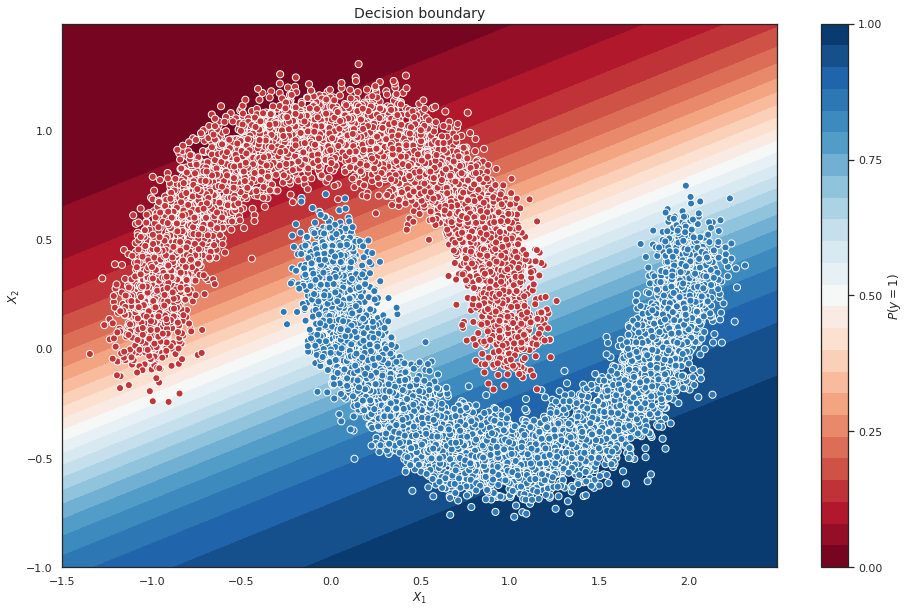

In [71]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [72]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for X_batch, _ in dataloader:
      optimizer.zero_grad()
      outp = model(X_batch) 
      preds = torch.sigmoid(outp)
      predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

    

In [73]:
model=linear_regression

In [74]:
from sklearn.metrics import accuracy_score

In [75]:
prr=predict(val_dataloader,model)

In [76]:
y_pre1=[]
for i in prr:
  if i >0.6:
    y_pre1.append(1)
  else:
    y_pre1.append(0)

In [77]:
accuracy_score(y_val,y_pre1)

0.8804

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.89

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [78]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms
transform = transforms.Compose(
    [transforms.ToTensor()])


root = './'
train_dataset = MNIST(root, train=True,  transform=transform, download=True)
val_dataset  = MNIST(root, train=False, transform=transform, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)


valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,shuffle=True,num_workers=2)


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [79]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [117]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    torch.nn.Linear(784, 128),
    torch.nn.ELU(),
    torch.nn.Linear(128, 10)).to(device)

In [118]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),1e-2)

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [119]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
          
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch.to(device))
              
                 
            else:

              model.eval()
              with torch.no_grad():
                outp = model(x_batch.to(device))

                 
            preds = outp.argmax(-1)
            correct = sum(preds==y_batch.to(device)) 
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss=criterion(outp,y_batch.to(device))
                loss.backward()
                optimizer.step()
                
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8927833333333334
Loader: valid. Accuracy: 0.9354
Epoch: 2
Loader: train. Accuracy: 0.9304
Loader: valid. Accuracy: 0.9458
Epoch: 3
Loader: train. Accuracy: 0.9406833333333333
Loader: valid. Accuracy: 0.9392
Epoch: 4
Loader: train. Accuracy: 0.9440333333333333
Loader: valid. Accuracy: 0.9302
Epoch: 5
Loader: train. Accuracy: 0.9502333333333334
Loader: valid. Accuracy: 0.9421
Epoch: 6
Loader: train. Accuracy: 0.9535333333333333
Loader: valid. Accuracy: 0.9494
Epoch: 7
Loader: train. Accuracy: 0.9551166666666666
Loader: valid. Accuracy: 0.9506
Epoch: 8
Loader: train. Accuracy: 0.9590333333333333
Loader: valid. Accuracy: 0.9577
Epoch: 9
Loader: train. Accuracy: 0.96225
Loader: valid. Accuracy: 0.9409
Epoch: 10
Loader: train. Accuracy: 0.96385
Loader: valid. Accuracy: 0.9586


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [120]:
elu_accuracy = accuracy["valid"]

In [ ]:
elu_accuracy

In [121]:

def test_activation_function(activation):
  if activation==Identical:
    model = nn.Sequential(nn.Flatten(),
                          torch.nn.Linear(784, 128),Identical(),
                          torch.nn.Linear(128, 10)).to(device)
  else:
    model = nn.Sequential(nn.Flatten(),
                          torch.nn.Linear(784, 128),
                          activation,
                          torch.nn.Linear(128, 10)).to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),1e-2)

  loaders = {"train": train_dataloader, "valid": valid_dataloader}

  max_epochs = 10
  accuracy = {"train": [], "valid": []}
  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
            
              if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
                
                  
              else:

                model.eval()
                with torch.no_grad():
                  outp = model(x_batch.to(device))

              preds = outp.argmax(-1)
              correct = sum(preds==y_batch.to(device)) 
              all = y_batch.size(0)
              epoch_correct += correct.item()
              epoch_all += all
              if k == "train":
                  loss=criterion(outp,y_batch.to(device))
                  loss.backward()
                  optimizer.step()
                  
          if k == "train":
              print(f"Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)

  return accuracy["valid"]


In [122]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(torch.nn.ReLU())
leaky_relu_accuracy = test_activation_function(torch.nn.LeakyReLU())

Epoch: 1
Loader: train. Accuracy: 0.8157666666666666
Loader: valid. Accuracy: 0.8537
Epoch: 2
Loader: train. Accuracy: 0.8498
Loader: valid. Accuracy: 0.8266
Epoch: 3
Loader: train. Accuracy: 0.8584
Loader: valid. Accuracy: 0.874
Epoch: 4
Loader: train. Accuracy: 0.8600333333333333
Loader: valid. Accuracy: 0.8717
Epoch: 5
Loader: train. Accuracy: 0.8629833333333333
Loader: valid. Accuracy: 0.8794
Epoch: 6
Loader: train. Accuracy: 0.8662666666666666
Loader: valid. Accuracy: 0.8431
Epoch: 7
Loader: train. Accuracy: 0.86695
Loader: valid. Accuracy: 0.8677
Epoch: 8
Loader: train. Accuracy: 0.8668166666666667
Loader: valid. Accuracy: 0.8584
Epoch: 9
Loader: train. Accuracy: 0.8687666666666667
Loader: valid. Accuracy: 0.8535
Epoch: 10
Loader: train. Accuracy: 0.8680666666666667
Loader: valid. Accuracy: 0.8505
Epoch: 1
Loader: train. Accuracy: 0.9012
Loader: valid. Accuracy: 0.9274
Epoch: 2
Loader: train. Accuracy: 0.9272333333333334
Loader: valid. Accuracy: 0.9327
Epoch: 3
Loader: train. Acc

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

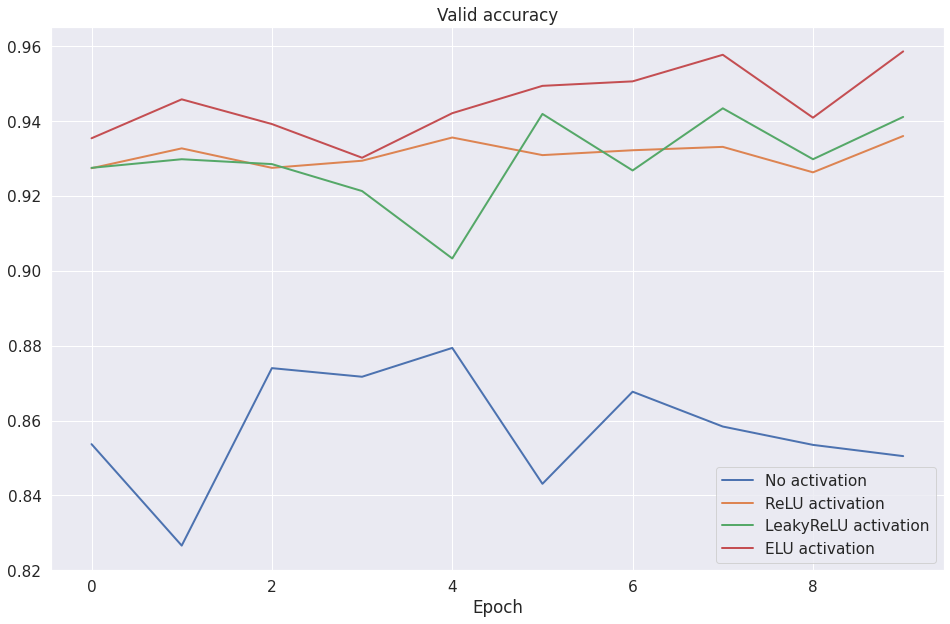

In [123]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

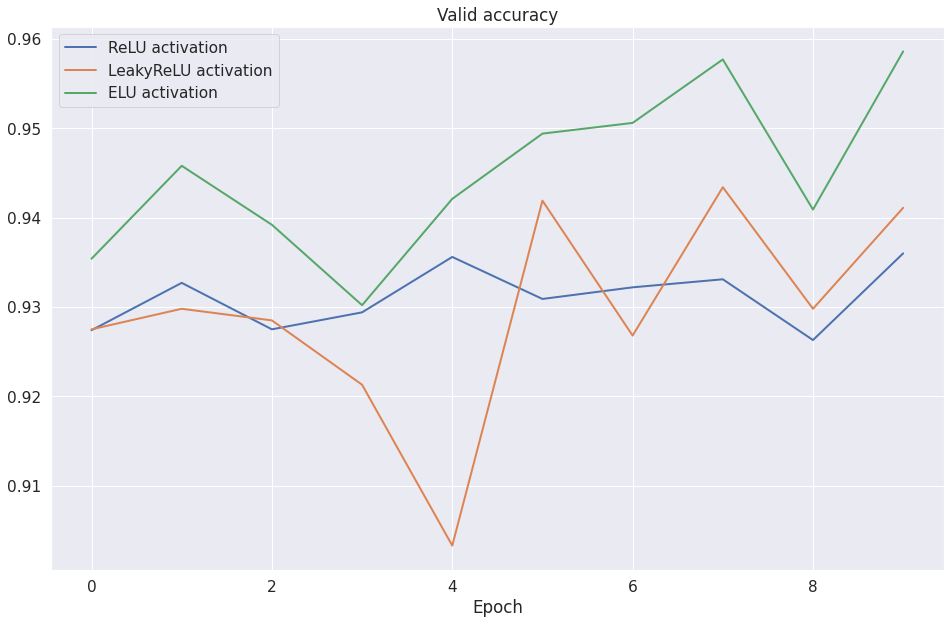

In [124]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

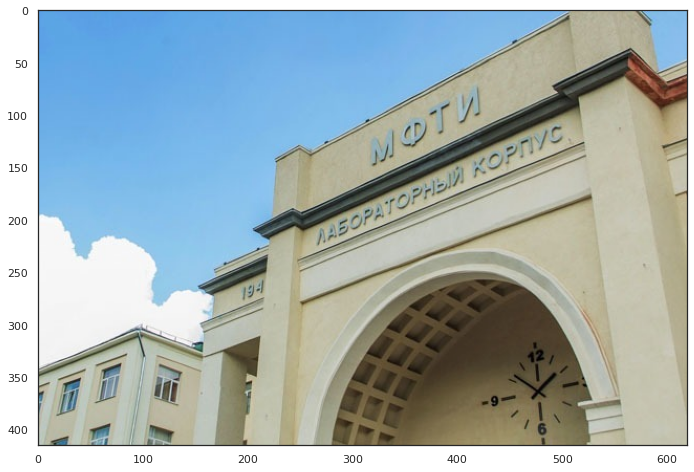

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
[1, -4, 1],
[0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0] 

 #

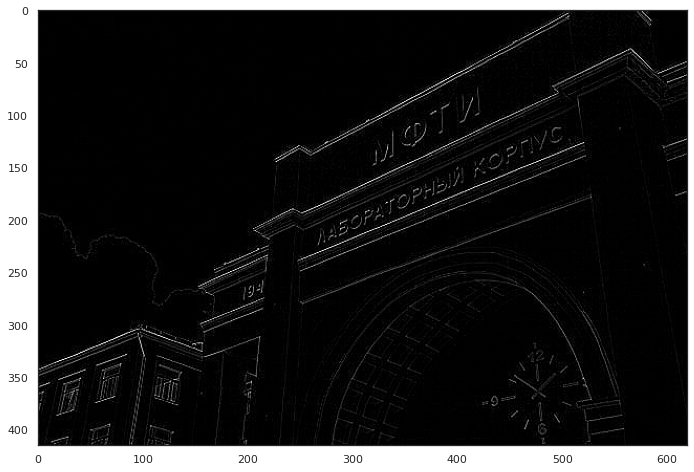

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

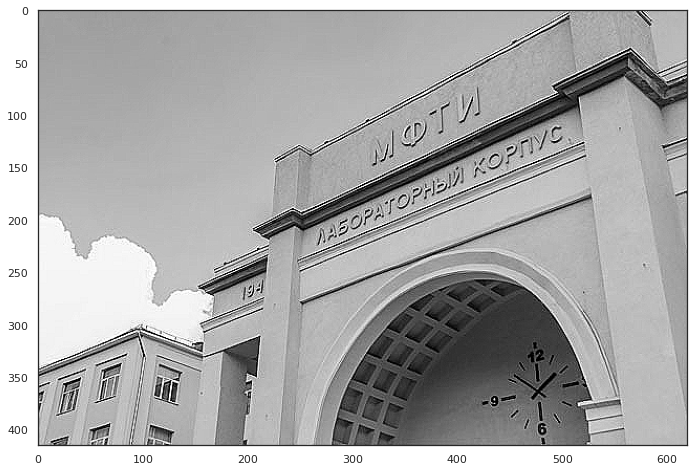

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
   [0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0] 

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**
1Е
2Д
3А
4В
5Б
6 Г


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [113]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16*5*5,120)  
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [114]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [115]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
          
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch.to(device))
                 
            else:

              model.eval()
              with torch.no_grad():
                outp = model(x_batch.to(device))

                 
            preds = outp.argmax(-1)
            correct = sum(preds==y_batch.to(device)) 
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss=criterion(outp,y_batch.to(device))
                loss.backward()
                optimizer.step()
                
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.949
Loader: valid. Accuracy: 0.98
Epoch: 2
Loader: train. Accuracy: 0.9816166666666667
Loader: valid. Accuracy: 0.983
Epoch: 3
Loader: train. Accuracy: 0.9860833333333333
Loader: valid. Accuracy: 0.9831
Epoch: 4
Loader: train. Accuracy: 0.988
Loader: valid. Accuracy: 0.9864
Epoch: 5
Loader: train. Accuracy: 0.9901833333333333
Loader: valid. Accuracy: 0.9861
Epoch: 6
Loader: train. Accuracy: 0.99085
Loader: valid. Accuracy: 0.9848
Epoch: 7
Loader: train. Accuracy: 0.9921333333333333
Loader: valid. Accuracy: 0.9889
Epoch: 8
Loader: train. Accuracy: 0.9926
Loader: valid. Accuracy: 0.9881
Epoch: 9
Loader: train. Accuracy: 0.9936333333333334
Loader: valid. Accuracy: 0.9872
Epoch: 10
Loader: train. Accuracy: 0.9934
Loader: valid. Accuracy: 0.9866


In [116]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

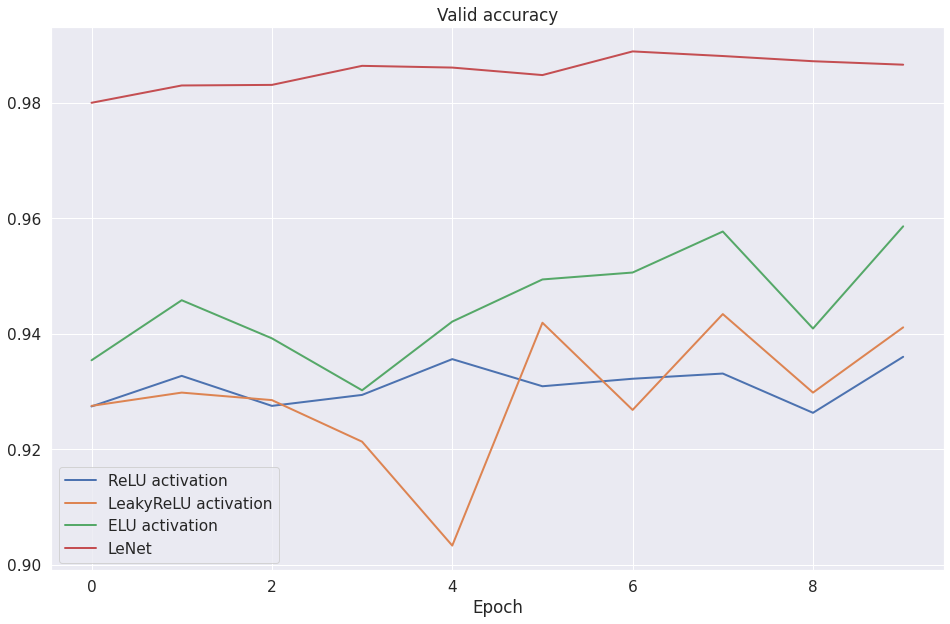

In [125]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [132]:
round(sum(lenet_accuracy)/len(lenet_accuracy),2)

0.99